In [44]:
install.packages("mice")

also installing the dependencies 'ucminf', 'ordinal', 'pan', 'jomo', 'mitml'


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [1]:
library(midasr)
library(tidyverse)
library(imputeTS)
library(dplyr)
library(glmnet)
library(dynlm)

Loading required package: sandwich

Loading required package: optimx

Loading required package: quantreg

Loading required package: SparseM

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

-- Attaching core tidyverse packages ------------------------ tidyverse 2.0.0 --
v dplyr     1.1.4     v readr     2.1.5
v forcats   1.0.0     v stringr   1.5.1
v ggplot2   3.5.1     v tibble    3.2.1
v lubridate 1.9.3     v tidyr     1.3.1
v purrr     1.0.2     
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
i Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: Matrix


Attaching package: 'Matrix'


The following objects are masked from 'package:tidyr':

    expand, pack, unpack


The following object is masked from 'package:SparseM':

    det


Loaded glmnet 4.1-8




Data setup and lag structure

In [103]:
gen_lagged_data <- function(metadata, data, last_date, lag) {
  # Filter data up to the last date
  lagged_data <- data %>%
    dplyr::filter(date <= last_date)
  
  # Store the date column separately
  date_col <- lagged_data$date
  
  # Debug: Print column names to check for discrepancies
  # print("Columns in lagged_data:")
  # print(colnames(lagged_data))
  
  # print("Series in metadata:")
  # print(metadata$series)
  
  # Loop through each series in the filtered metadata
  for (series_name in metadata$series) {
    # Check if the series exists in the data
    if (!series_name %in% colnames(lagged_data)) {
      warning(paste("Series", series_name, "from metadata not found in data"))
      next
    }
    
    pub_lag <- metadata %>%
      dplyr::filter(series == series_name) %>%
      select(months_lag) %>%
      pull()

    # Calculate the condition for applying NA
    condition <- (nrow(lagged_data) - pub_lag - lag)
    
    # Debugging information
    # print(paste("Series:", series_name, "Pub Lag:", pub_lag, "Lag:", lag, "Condition:", condition))
    
    # Apply NA if the condition is valid
    if (!is.na(condition) && condition > 0 && condition <= nrow(lagged_data)) {
      lagged_data[condition:nrow(lagged_data), series_name] <- NA
    } else {
      warning(paste("Invalid condition for series:", series_name))
    }
  }
  
  # Reattach the date column
  lagged_data$date <- date_col
  
  # Filter out rows where the date is NA
  lagged_data <- lagged_data %>%
    dplyr::filter(!is.na(date))
  
  return(lagged_data)
}

In [1]:
library(readr)
library(dplyr)
library(caret)
library(glmnet)
library(Metrics)

# Set up the directory
current_dir <- getwd()
print(current_dir)
project_dir <- file.path(current_dir, "..")
print(project_dir)
setwd(project_dir)

# Load the data
data_path <- file.path("data", "data_files", "processed_data", "em_imputed_stationary.csv")
if (file.exists(data_path)) {
  data <- read_csv(data_path, show_col_types = FALSE)
} else {
  stop("Data file not found. Please check the file path.")
}

# Return to the original directory
setwd(current_dir)

# Convert 'date' column to Date type and set as index if needed (not commonly done in R)
data <- data %>% arrange(date)

# Fit features and target
target_variable <- "China: GDP: Current Prices:PoP GROWTHRATE"
X <- data %>% select(-all_of(target_variable))
y <- data[[target_variable]]

# Set a seed for reproducibility
set.seed(42)

# Split the data into training and testing sets
trainIndex <- createDataPartition(y, p = 0.8, list = FALSE)
X_train <- X[trainIndex, ]
X_test <- X[-trainIndex, ]
y_train <- y[trainIndex]
y_test <- y[-trainIndex]

# Scale the features
scaler <- preProcess(X_train, method = c("center", "scale"))
X_train_scaled <- predict(scaler, X_train)
X_test_scaled <- predict(scaler, X_test)

# Perform cross-validation to find the optimal lambda
cv_model <- cv.glmnet(as.matrix(X_train_scaled), y_train, alpha = 1)

# Get the best lambda value
best_lambda <- cv_model$lambda.min

# Train the Lasso model with the best lambda
lasso_model <- glmnet(as.matrix(X_train_scaled), y_train, alpha = 1, lambda = best_lambda)

# Make predictions
y_pred <- predict(lasso_model, s = best_lambda, newx = as.matrix(X_test_scaled))

# Evaluate the model
mse <- mean((y_test - y_pred)^2)
r2 <- 1 - sum((y_test - y_pred)^2) / sum((y_test - mean(y_test))^2)

cat("Mean squared error:", round(mse, 4), "\n")
cat("R-squared score:", round(r2, 4), "\n")

# Get the coefficients
coef <- coef(lasso_model, s = best_lambda)

# Identify the selected features (non-zero coefficients)
selected_features <- which(coef != 0)[-1]  # Ignore the intercept
selected_feature_names <- colnames(X)[selected_features]

# Display the selected features
cat("Number of features selected by Lasso:", length(selected_features), "\n")
cat("Selected features:", selected_feature_names, "\n")
cat("Coefficients of selected features:", coef[selected_features], "\n")

# Optionally, create a data frame of selected features and their coefficients
selected_features_df <- data.frame(
  'Selected Features' = selected_feature_names,
  'Coefficients' = coef[selected_features]
)
print(selected_features_df)


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Loading required package: ggplot2

Loading required package: lattice

Loading required package: Matrix

Loaded glmnet 4.1-8


Attaching package: 'Metrics'


The following objects are masked from 'package:caret':

    precision, recall




[1] "/Users/leyixu/Desktop/Nowcast/main"
[1] "/Users/leyixu/Desktop/Nowcast/main/.."


Warning message in storage.mode(xd) <- "double":
"NAs introduced by coercion"
Warning message in storage.mode(xd) <- "double":
"NAs introduced by coercion"
Warning message in storage.mode(xd) <- "double":
"NAs introduced by coercion"
Warning message in storage.mode(xd) <- "double":
"NAs introduced by coercion"
Warning message in storage.mode(xd) <- "double":
"NAs introduced by coercion"
Warning message in storage.mode(xd) <- "double":
"NAs introduced by coercion"
Warning message in storage.mode(xd) <- "double":
"NAs introduced by coercion"
Warning message in storage.mode(xd) <- "double":
"NAs introduced by coercion"
Warning message in storage.mode(xd) <- "double":
"NAs introduced by coercion"
Warning message in storage.mode(xd) <- "double":
"NAs introduced by coercion"
Warning message in storage.mode(xd) <- "double":
"NAs introduced by coercion"
Warning message in cbind2(1, newx) %*% nbeta:
"NAs introduced by coercion"
Warning message in cbind2(1, newx) %*% nbeta:
"NAs introduced by co

Mean squared error: 33.8058 
R-squared score: 0.4002 
Number of features selected by Lasso: 23 
Selected features: Surveyed Urban Unemployment Rate in 31 Big Cities and Towns:PoP chg China: Total Retail Sales of Consumer Goods:PoP GROWTHRATE China: Total Retail Sales of Consumer Goods: Merchandise Retail:PoP GROWTHRATE China: Total Retail Sales of Consumer Goods: Retail Sales of the Enterprises (units) excluding Vehicles:PoP GROWTHRATE China: Value of Imports and Exports:PoP GROWTHRATE China: Trade Balance:Combine With Forecast:PoP GROWTHRATE ChinaBond: Government Bond YTM: 10Y:PoP chg Percent Change: SSE Composite Index Percent Change: CSI 300 Index USA: Wilshire 5000 Total Market Full Cap Index:PoP GROWTHRATE China: Financial Institutions: New RMB Loans:PoP GROWTHRATE China: M1:PoP GROWTHRATE China: Credit Lending Weighted Interest Rate of Depository Institutions: 3M:PoP chg China: Steel Industry PMI:PoP chg China Forestry Purchasing Managers' Index:PoP chg China: CPI: Fixed-base Ind

In [2]:
library(lubridate)

# Set up the directory
setwd(project_dir)

# Load the data
data_path <- file.path("data", "data_files", "processed_data", "em_imputed_mq_stationary.csv")
data <- read_csv(data_path)
metadata_path <- file.path("data", "data_files", "processed_data", "meta_monthly_blocks.csv")
metadata <- read_csv(metadata_path)

# Return to the original directory
setwd(current_dir)

target_variable <- "China: GDP: Current Prices:PoP GROWTHRATE"

# Function to standardize a single column
z_score <- function(x) {
  (x - mean(x, na.rm = TRUE)) / sd(x, na.rm = TRUE)
}

# Applying standardization to the entire dataframe
normalized <- data
normalized[ , !(names(normalized) %in% "date")] <- lapply(normalized[ , !(names(normalized) %in% "date")], z_score)
data <- normalized

# Create a data frame with the selected features
selected_data <- data %>%
  select(all_of(selected_feature_names))

# Add the target variable to the selected data
selected_data[[target_variable]] <- data[[target_variable]]
selected_data$date <- data$date
data <- selected_data
 data$date <- as.Date(data$date)

data$quarter <- quarter(data$date)

data <- data %>%
  mutate(Q1 = ifelse(quarter == 1, 1, 0),
         Q2 = ifelse(quarter == 2, 1, 0),
         Q3 = ifelse(quarter == 3, 1, 0),
         Q4 = ifelse(quarter == 4, 1, 0))

data$quarter <- NULL

tail(data)

# which lags to assess
lags <- 0:3

# dates for training and test
# test set is shorter in this example notebook than in the paper to save runtime. Set test_start_date to "2002-03-01" and test_end_date to "2022-09-01" for results of the paper.
train_start_date <- as.Date("1992-06-30")
test_start_date <- as.Date("2018-06-30")
test_end_date <- as.Date("2024-06-30")

# will have a rolling test period
# This mimics the real-world nowcasting scenario
# Generate the sequence of quarterly end dates
# Define a function to get the last day of the quarter
last_day_of_quarter <- function(date) {
  quarter_end_month <- c("03-31", "06-30", "09-30", "12-31")
  year <- year(date)
  quarter <- ceiling(month(date) / 3)
  as.Date(paste0(year, "-", quarter_end_month[quarter]))
}

# Generate the sequence of dates
test_dates <- seq(as.Date(test_start_date), as.Date(test_end_date), by = "quarter")

# Apply the function to align to the last day of each quarter
test_dates <- sapply(test_dates, last_day_of_quarter)

# Convert the result to Date type
test_dates <- as.Date(test_dates)

print(test_dates)

# test dataset
test <- dplyr::filter(data, date >= test_start_date, date <= test_end_date) %>%
    as.data.frame()
head(test)
tail(test)

# replace any infinites with NA
for (col in colnames(test)) {
    if (sum(is.infinite(test[,col])) > 0) {
      test[is.infinite(test[,col]), col] <- NA 
    }
}


Attaching package: 'lubridate'


The following objects are masked from 'package:base':

    date, intersect, setdiff, union


Rows: 388 Columns: 85
-- Column specification --------------------------------------------------------
Delimiter: ","
dbl  (84): China: Financial Institutions: Total Deposits Balance: RMB:PoP GR...
date  (1): date

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 84 Columns: 13
-- Column specification --------------------------------------------------------
Delimiter: ","
chr  (2): series, freq
dbl (11): months_lag, block_g1, block_g2, block_1, block_2, block_3, block_4...

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


Surveyed Urban Unemployment Rate in 31 Big Cities and Towns:PoP chg,China: Total Retail Sales of Consumer Goods:PoP GROWTHRATE,China: Total Retail Sales of Consumer Goods: Merchandise Retail:PoP GROWTHRATE,China: Total Retail Sales of Consumer Goods: Retail Sales of the Enterprises (units) excluding Vehicles:PoP GROWTHRATE,China: Value of Imports and Exports:PoP GROWTHRATE,China: Trade Balance:Combine With Forecast:PoP GROWTHRATE,ChinaBond: Government Bond YTM: 10Y:PoP chg,Percent Change: SSE Composite Index,Percent Change: CSI 300 Index,USA: Wilshire 5000 Total Market Full Cap Index:PoP GROWTHRATE,...,China: PPI: Means of Production: MoM,Nominal Effective Exchange Rate Index: CNY:PoP GROWTHRATE,USD/CNY: Spot Exchange Rate:PoP GROWTHRATE,China: Industrial Capacity Utilization:PoP chg,China: GDP: Current Prices:PoP GROWTHRATE,date,Q1,Q2,Q3,Q4
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<date>,<dbl>,<dbl>,<dbl>,<dbl>
-0.9188276683,-0.08402106,0.8176588,0.9730091,-0.09017276,0.1308635,-0.2772651,-1.022874438,-0.92660063,-0.163755646,...,-0.4279185,-0.05237957,-1.0449199,NA,NA,2024-01-31,1,0,0,0
1.8379713902,-0.27163297,-0.6018259,-0.5486043,-1.94504173,-1.1928065,0.1236452,1.279222274,1.75614482,-0.010577760,...,-0.6294790,0.39559230,-1.0478451,NA,NA,2024-02-29,1,0,0,0
0.0001053512,0.13443789,0.1074073,0.2116566,1.45470842,0.5351504,0.2357516,-0.001452595,-0.02950090,-0.087111762,...,-0.2263579,-0.30595217,0.1110447,-0.6450470,-1.5095442,2024-03-31,1,0,0,0
-0.9188276683,-1.03208247,-1.9288132,-1.8406969,0.09830086,0.2607267,-0.7650984,-0.202516212,-0.56899552,-0.003109797,...,-0.4279185,0.62023719,0.2812928,NA,NA,2024-04-30,0,1,0,0
-0.9188276683,2.01657110,1.5632701,1.9328455,0.07548939,0.1450710,0.3028130,-0.130732823,-0.43753871,-0.057159003,...,0.7814449,-0.24603953,1.5967426,NA,NA,2024-05-31,0,1,0,0
0.0001053512,-0.61647597,0.4534084,0.5496941,-0.12694365,0.2148954,0.1768693,-0.013940309,-0.04422492,-0.072174439,...,-0.4279185,-0.11334327,0.1546787,0.5698027,0.3693988,2024-06-30,0,1,0,0


 [1] "2018-06-30" "2018-09-30" "2018-12-31" "2019-03-31" "2019-06-30"
 [6] "2019-09-30" "2019-12-31" "2020-03-31" "2020-06-30" "2020-09-30"
[11] "2020-12-31" "2021-03-31" "2021-06-30" "2021-09-30" "2021-12-31"
[16] "2022-03-31" "2022-06-30" "2022-09-30" "2022-12-31" "2023-03-31"
[21] "2023-06-30" "2023-09-30" "2023-12-31" "2024-03-31" "2024-06-30"


,Surveyed Urban Unemployment Rate in 31 Big Cities and Towns:PoP chg,China: Total Retail Sales of Consumer Goods:PoP GROWTHRATE,China: Total Retail Sales of Consumer Goods: Merchandise Retail:PoP GROWTHRATE,China: Total Retail Sales of Consumer Goods: Retail Sales of the Enterprises (units) excluding Vehicles:PoP GROWTHRATE,China: Value of Imports and Exports:PoP GROWTHRATE,China: Trade Balance:Combine With Forecast:PoP GROWTHRATE,ChinaBond: Government Bond YTM: 10Y:PoP chg,Percent Change: SSE Composite Index,Percent Change: CSI 300 Index,USA: Wilshire 5000 Total Market Full Cap Index:PoP GROWTHRATE,...,China: PPI: Means of Production: MoM,Nominal Effective Exchange Rate Index: CNY:PoP GROWTHRATE,USD/CNY: Spot Exchange Rate:PoP GROWTHRATE,China: Industrial Capacity Utilization:PoP chg,China: GDP: Current Prices:PoP GROWTHRATE,date,Q1,Q2,Q3,Q4
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<date>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.0001053512,-0.5080856,0.1160577,0.02618491,-0.21905079,0.77318760,0.162150945,-0.01706176,-0.04790536,-0.06844068,...,0.7814449,-0.57652803,0.1655855,0.23262649,0.5611695,2018-06-30,0,1,0,0
2,2.7569044096,-0.2135788,-0.1853695,-0.12421629,0.13278123,-0.64337310,-0.585930503,0.14757838,0.01260036,0.70739702,...,0.1767632,-2.94361050,-0.4587980,NA,NA,2018-07-31,0,0,1,0
3,-0.9188276683,0.3244711,0.2640928,-0.09531485,0.04913884,-0.11965412,0.036722133,-0.33178284,-0.52763952,0.03066267,...,0.9830055,-1.21373561,-1.4468238,NA,NA,2018-08-31,0,0,1,0
4,-1.8377606877,-0.1266229,0.1892224,-0.10366339,0.15558760,0.15428805,0.123645151,-0.02798970,-0.06079028,-0.05536910,...,1.3861266,0.03292295,0.2037693,0.03032074,0.1120281,2018-09-30,0,0,1,0
5,0.0001053512,0.9927634,1.6421086,-0.20449466,-0.45458222,0.07322071,-0.007626345,0.88536990,1.27412859,1.47794868,...,1.1845661,-0.48108629,1.2366199,NA,NA,2018-10-31,0,0,0,1
6,0.0001053512,-1.2410039,-0.6143195,0.14043077,0.11574583,0.29976010,0.036722133,0.51886815,1.00420539,1.00114660,...,-0.6294790,-0.18354906,2.5562066,NA,NA,2018-11-30,0,0,0,1


,Surveyed Urban Unemployment Rate in 31 Big Cities and Towns:PoP chg,China: Total Retail Sales of Consumer Goods:PoP GROWTHRATE,China: Total Retail Sales of Consumer Goods: Merchandise Retail:PoP GROWTHRATE,China: Total Retail Sales of Consumer Goods: Retail Sales of the Enterprises (units) excluding Vehicles:PoP GROWTHRATE,China: Value of Imports and Exports:PoP GROWTHRATE,China: Trade Balance:Combine With Forecast:PoP GROWTHRATE,ChinaBond: Government Bond YTM: 10Y:PoP chg,Percent Change: SSE Composite Index,Percent Change: CSI 300 Index,USA: Wilshire 5000 Total Market Full Cap Index:PoP GROWTHRATE,...,China: PPI: Means of Production: MoM,Nominal Effective Exchange Rate Index: CNY:PoP GROWTHRATE,USD/CNY: Spot Exchange Rate:PoP GROWTHRATE,China: Industrial Capacity Utilization:PoP chg,China: GDP: Current Prices:PoP GROWTHRATE,date,Q1,Q2,Q3,Q4
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<date>,<dbl>,<dbl>,<dbl>,<dbl>
68,-0.9188276683,-0.08402106,0.8176588,0.9730091,-0.09017276,0.1308635,-0.2772651,-1.022874438,-0.92660063,-0.163755646,...,-0.4279185,-0.05237957,-1.0449199,NA,NA,2024-01-31,1,0,0,0
69,1.8379713902,-0.27163297,-0.6018259,-0.5486043,-1.94504173,-1.1928065,0.1236452,1.279222274,1.75614482,-0.010577760,...,-0.6294790,0.39559230,-1.0478451,NA,NA,2024-02-29,1,0,0,0
70,0.0001053512,0.13443789,0.1074073,0.2116566,1.45470842,0.5351504,0.2357516,-0.001452595,-0.02950090,-0.087111762,...,-0.2263579,-0.30595217,0.1110447,-0.6450470,-1.5095442,2024-03-31,1,0,0,0
71,-0.9188276683,-1.03208247,-1.9288132,-1.8406969,0.09830086,0.2607267,-0.7650984,-0.202516212,-0.56899552,-0.003109797,...,-0.4279185,0.62023719,0.2812928,NA,NA,2024-04-30,0,1,0,0
72,-0.9188276683,2.01657110,1.5632701,1.9328455,0.07548939,0.1450710,0.3028130,-0.130732823,-0.43753871,-0.057159003,...,0.7814449,-0.24603953,1.5967426,NA,NA,2024-05-31,0,1,0,0
73,0.0001053512,-0.61647597,0.4534084,0.5496941,-0.12694365,0.2148954,0.1768693,-0.013940309,-0.04422492,-0.072174439,...,-0.4279185,-0.11334327,0.1546787,0.5698027,0.3693988,2024-06-30,0,1,0,0


Model training

In [151]:
# dataframe for predictions
pred_dict <- data.frame(date = test_dates)
for (lag in lags) {
  pred_dict[,as.character(lag)] <- NA
}


In [152]:
# Filter metadata to keep only the series that are present in the data
metadata <- metadata %>%
  dplyr::filter(series %in% colnames(data))

In [169]:
#mean imputation
library(dplyr)
library(lubridate)
library(tidyr)
library(midasr)
library(imputeTS)

# For loop for each test date
i <- 1
for (i in seq_along(test_dates)) {
  test_date <- test_dates[i]
  test_date
  
  # Train data up to 3 months before test date
  train <- data %>%
    filter(date >= train_start_date & date <= ceiling_date(test_date, "month") %m-% days(1)) 
  train <- train[-1, ]
  head(train)
  tail(train)
    
  # Estimating MIDAS models
  y <- train[substr(train$date, 6, 7) %in% c("03", "06", "09", "12"), target_variable]

  y <- y[[1]] # vector

  models <- list()

  # Train separate MIDAS models for each explanatory variable
  for (col in colnames(train)[2:ncol(train)]) {
    if (col != target_variable && col != "date") {
      if (col %in% c("China: Industrial Capacity Utilization:PoP chg")) { # quarterly variables
        x <- train[substr(train$date, 6, 7) %in% c("03", "06", "09", "12"), col]
        x <- x[[1]] # vector
        models[[col]] <- midas_r(y ~ mls(x, 0:1, 1, nealmon), start = list(x = c(1, -0.5)))
      } else { # monthly variables
        x <- train[, col]
        x <- x[[1]] # vector
        models[[col]] <- midas_r(y ~ mls(x, 0:3, 3, nealmon), start = list(x = c(1, -0.5)))
        forecast(models[[col]], newdata = list(x=x))
      }
    }
  }

  # Calculate RMSE for weighting
  weight <- list()
  for (col in colnames(train)[2:ncol(train)]) {
    if (col != target_variable && col != "date") {
      fitted <- models[[col]]$fitted.values
      actual <- y[2:length(y)]
      weight[[col]] <- sqrt(mean((fitted - actual)^2))
    }
  }

  # Adjust and normalize weights
  adj <- abs(unlist(weight) - max(unlist(weight)))
  weight <- adj / sum(adj)
  weight

  # Testing the model on artificial vintages  
  for (lag in lags) {
    lagged_data <- gen_lagged_data(metadata, data, test_dates[i], lag) 

    # Make sure actual value not in there
    lagged_data[lagged_data$date == test_dates[i], target_variable] <- NA

    # Separate quarterly and monthly variables
    quarterly_vars <- c("China: Industrial Capacity Utilization:PoP chg", 
                        "China: GDP: Current Prices:PoP GROWTHRATE")
    
    monthly_vars <- setdiff(colnames(lagged_data), c(quarterly_vars, "date", target_variable))

    # Impute monthly variables
    lagged_data[monthly_vars] <- na_mean(lagged_data[monthly_vars])

    # Impute quarterly variables, preserving NAs for non-quarter months
    for (var in quarterly_vars) {
        quarterly_data <- lagged_data[substr(lagged_data$date, 6, 7) %in% c("03", "06", "09", "12"), var]
        imputed_quarterly <- na_mean(quarterly_data)
        lagged_data[substr(lagged_data$date, 6, 7) %in% c("03", "06", "09", "12"), var] <- imputed_quarterly
    }

    y <- lagged_data[substr(lagged_data$date, 6, 7) %in% c("03", "06", "09", "12"), target_variable]
    y <- y[[1]]
    preds <- list()

    # Loop through all the individual models to get predictions
    for (col in colnames(train)[2:(ncol(train)-1)]) {
      if (col != target_variable && col != "date") {
        if (col %in% c("China: Industrial Capacity Utilization:PoP chg")) { # Quarterly variables
          x <- lagged_data[substr(lagged_data$date, 6, 7) %in% c("03", "06", "09", "12"), col][[1]]
          preds[[col]] <- forecast(models[[col]], newdata = list(x = x))$mean
          preds[[col]] <- preds[[col]][length(preds[[col]])]
        } else { # Monthly variables
          x <- lagged_data[, col][[1]][-1] # -1 can be changed
          preds[[col]] <- forecast(models[[col]], newdata = list(x = x))$mean
          preds[[col]] <- preds[[col]][length(preds[[col]])]
        }
      }
    }
    
    # Ensure preds and weight have the same length
    valid_preds <- preds[names(preds) %in% names(weight)]
    valid_weights <- weight[names(weight) %in% names(valid_preds)]
    
    # Averaged predictions using weighted mean
    if (length(valid_preds) > 0 && length(valid_weights) > 0) {
      pred_dict[pred_dict$date == test_dates[i], as.character(lag)] <- weighted.mean(unlist(valid_preds), unlist(valid_weights))
    } else {
      warning(paste("No valid predictions for date", test_dates[i], "and lag", lag))
      pred_dict[pred_dict$date == test_dates[i], as.character(lag)] <- NA
    }
  }
}

# Display the predictions
print(pred_dict)

         date            0          1          2          3
1  2018-06-30  0.190932146  0.2117662  0.1559194  0.1572481
2  2018-09-30  0.072073512  0.1078838  0.1776339  0.1755438
3  2018-12-31  0.260910758  0.1470168  0.1518944  0.1510013
4  2019-03-31 -0.853438275 -0.8375160 -0.8454287 -0.8442023
5  2019-06-30  0.275958445  0.3404942  0.1582490  0.1604585
6  2019-09-30  0.040990706  0.1090764  0.1794143  0.1769302
7  2019-12-31  0.234904796  0.1374375  0.1514773  0.1503111
8  2020-03-31 -0.920651074 -0.8216821 -0.8776598 -0.8494219
9  2020-06-30  0.452015976  0.3654899  0.1523543  0.1634162
10 2020-09-30  0.034472400  0.1273725  0.1780285  0.1810240
11 2020-12-31  0.205714985  0.1816067  0.1465100  0.1498239
12 2021-03-31 -0.862613396 -0.8131588 -0.8450625 -0.8453532
13 2021-06-30  0.194059536  0.2703977  0.1648035  0.1681634
14 2021-09-30 -0.003904486  0.1633083  0.1761009  0.1743571
15 2021-12-31  0.257006808  0.2522414  0.1452845  0.1450561
16 2022-03-31 -0.884176163 -0.8430395 -0

Model evaluation

Vintage,RMSE
<dbl>,<dbl>
0,0.5509
1,0.5745
2,0.5920
3,0.5945


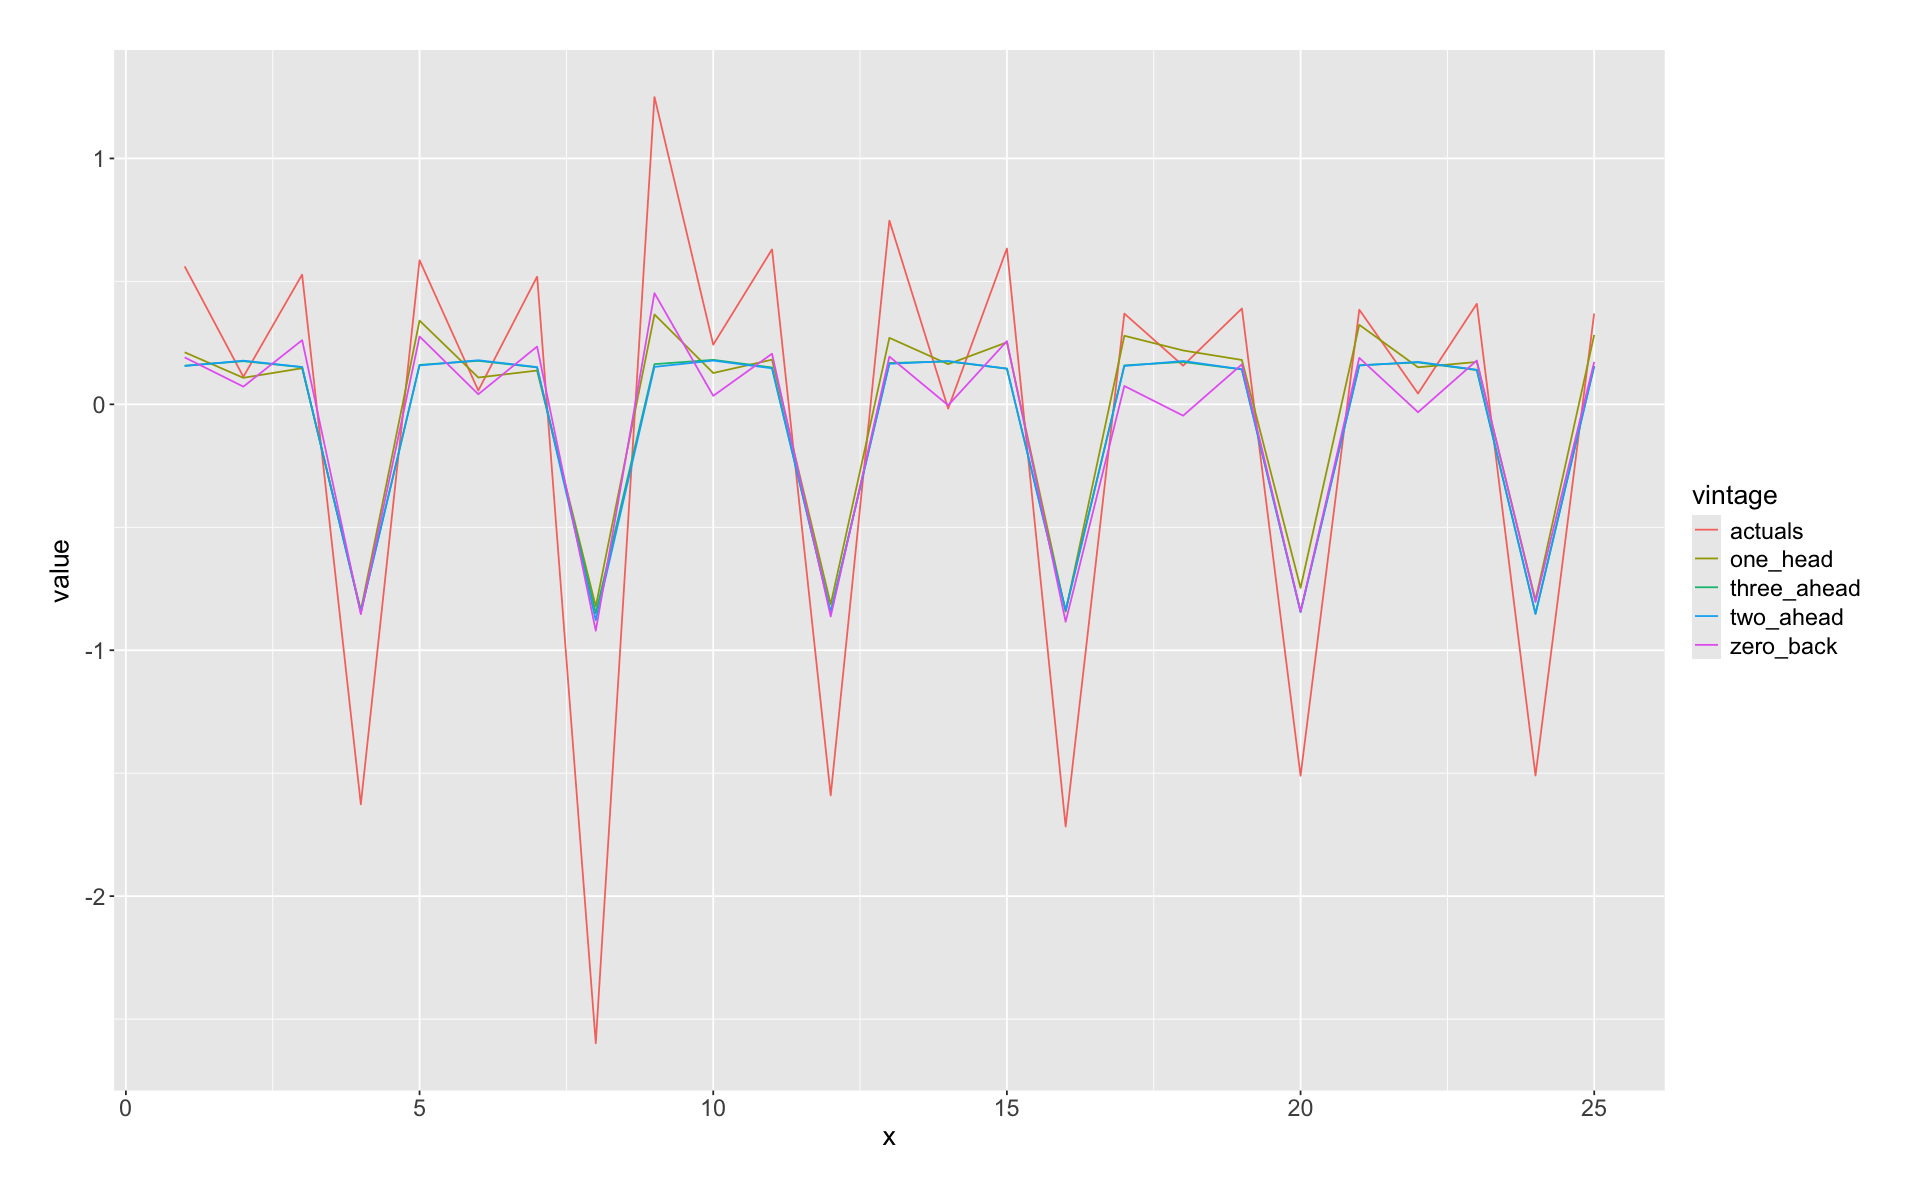

In [170]:

actuals <- test %>%
    filter(date >= test_start_date) %>%
    filter(substr(date, 6, 7) %in% c("03", "06", "09", "12")) %>%
    select(!!target_variable) %>%
    pull()

performance <- data.frame(Vintage = numeric(), RMSE = numeric())
for (lag in lags) {
    tmp = data.frame(
        Vintage = lag,
        RMSE = sqrt(mean((actuals - pred_dict[,as.character(lag)])**2))
    )
    performance = rbind(performance, tmp)
}
round(performance, 4)

p <- tibble(
    actuals = actuals,
    zero_back = pred_dict[, "0"],
    one_head = pred_dict[, "1"],
    two_ahead = pred_dict[, "2"],
    three_ahead = pred_dict[, "3"]
) %>%
    mutate(x = 1:n()) %>%
    gather(vintage, value, -x) %>%
    ggplot() + 
    aes(x = x, y = value, color = vintage) + 
    geom_line() +
    theme(
        plot.title = element_text(size = 20),
        axis.title = element_text(size = 16),
        axis.text = element_text(size = 14),
        legend.text = element_text(size = 14),
        legend.title = element_text(size = 16),
        plot.margin = margin(30, 30, 30, 30)
    )
options(repr.plot.width = 16, repr.plot.height = 10)

print(p)


In [171]:
# Save predictions to CSV
setwd(project_dir)
write.csv(pred_dict, file = file.path('results', 'midas.csv'), row.names = FALSE)

# Verify if the file was created successfully
if (file.exists(file.path('results', 'midas.csv'))) {
  print("CSV file successfully saved.")
} else {
  print("Error: CSV file was not saved. Please check the file path and permissions.")
}